Block size = 1 x 1  ->  Time taken = 0.082826 sec
Block size = 2 x 2  ->  Time taken = 0.000385 sec
Block size = 4 x 4  ->  Time taken = 0.000143 sec
Block size = 8 x 8  ->  Time taken = 0.000084 sec
Block size = 12 x 12  ->  Time taken = 0.000081 sec
Block size = 16 x 16  ->  Time taken = 0.000097 sec
Block size = 20 x 20  ->  Time taken = 0.000080 sec
Block size = 24 x 24  ->  Time taken = 0.000086 sec
Block size = 28 x 28  ->  Time taken = 0.000099 sec
Block size = 32 x 32  ->  Time taken = 0.000081 sec


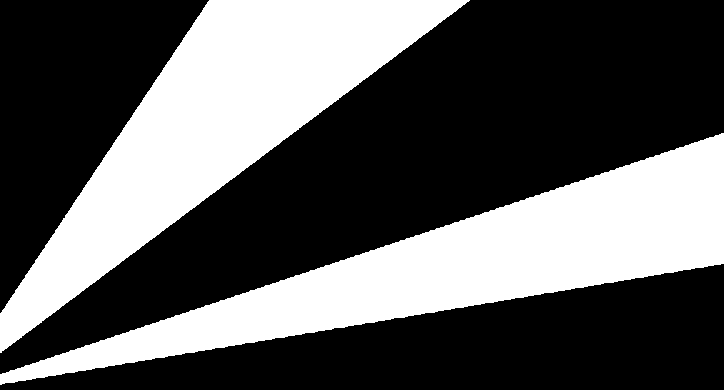

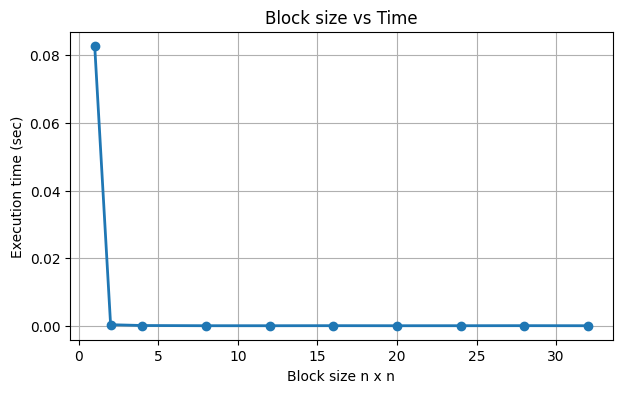

In [19]:
#### Binarization ####

from PIL import Image
import time
import numpy as np
from numba import cuda, config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

# Function to convert in a grey image
@cuda.jit   # For GPU
def binarization_gpu(src, dst, limit):
    tidx1, tidx2 = cuda.grid(2)
    if tidx1 < src.shape[0] and tidx2 < src.shape[1]: # Image limit
        r = src[tidx1, tidx2, 0]
        g = src[tidx1, tidx2, 1]
        b = src[tidx1, tidx2, 2]
        gy = np.uint8((r + g + b) / 3)  # Average of pixels
        if gy < limit :
          dst[tidx1, tidx2] = 0 # The 3 pixels become white
        else :
          dst[tidx1, tidx2] = 255 # The 3 pixels become dark

img = Image.open("/content/image.PNG").convert("RGB") # Load image
rgb_array = np.array(img, dtype=np.uint8)

dst = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8) # Allow memory
block_sizes = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32] # Different block size values
times = [] # Timer

d_src = cuda.to_device(rgb_array)   # Input
d_dst = cuda.device_array_like(dst)  # Output
limit = 128

# The Loop
for threads_per_block in block_sizes:

    blocks_x = int(np.ceil(rgb_array.shape[0] / threads_per_block))
    blocks_y = int(np.ceil(rgb_array.shape[1] / threads_per_block))

    start_time = time.time() # Timer
    binarization_gpu[(blocks_x, blocks_y), (threads_per_block, threads_per_block)](d_src, d_dst, limit) # Function for greyscaling
    end_time = time.time()

    d_dst.copy_to_host(dst)

    time_ = end_time - start_time # Timer
    times.append(time_)
    print(f"Block size = {threads_per_block} x {threads_per_block}  ->  Time taken = {time_:.6f} sec")

# Display and result
result = d_dst.copy_to_host()
result_c = np.clip(result, 0, 255).astype(np.uint8) # Converting
img_result = Image.fromarray(result_c)
display(img_result)

# Graph
plt.figure(figsize=(7,4))
plt.plot(block_sizes, times, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Block size n x n')
plt.ylabel('Execution time (sec)')
plt.title('Block size vs Time')
plt.grid(True)
plt.show()

Block size = 1 x 1  ->  Time taken = 0.088435 sec
Block size = 2 x 2  ->  Time taken = 0.000454 sec
Block size = 4 x 4  ->  Time taken = 0.000327 sec
Block size = 8 x 8  ->  Time taken = 0.000149 sec
Block size = 12 x 12  ->  Time taken = 0.000162 sec
Block size = 16 x 16  ->  Time taken = 0.000126 sec
Block size = 20 x 20  ->  Time taken = 0.000108 sec
Block size = 24 x 24  ->  Time taken = 0.000102 sec
Block size = 28 x 28  ->  Time taken = 0.000107 sec
Block size = 32 x 32  ->  Time taken = 0.000130 sec


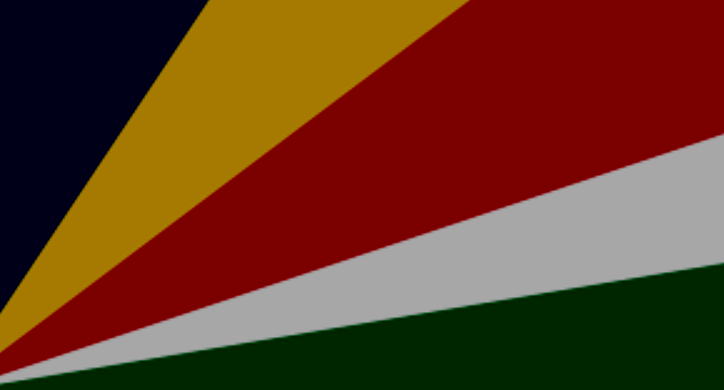

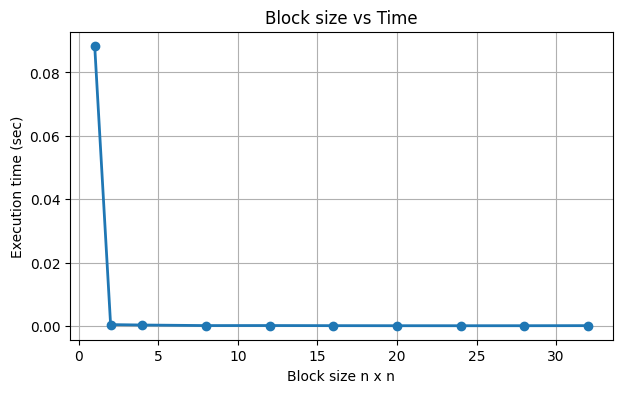

In [39]:
#### Brightness ####

from PIL import Image
import time
import numpy as np
from numba import cuda, config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

# Function to convert in a bright image
@cuda.jit   # For GPU
def brightness_gpu(src, dst, brightness):
    tidx1, tidx2 = cuda.grid(2)
    if tidx1 < src.shape[0] and tidx2 < src.shape[1]: # Image limit
        dst[tidx1, tidx2, 0] = min(max(src[tidx1, tidx2, 0] + brightness, 0), 255) # The 3 pixels become brighter or darker
        dst[tidx1, tidx2, 1] = min(max(src[tidx1, tidx2, 1] + brightness, 0), 255)
        dst[tidx1, tidx2, 2] = min(max(src[tidx1, tidx2, 2] + brightness, 0), 255)

img = Image.open("/content/image.PNG").convert("RGB") # Load image
rgb_array = np.array(img, dtype=np.uint8)

dst = np.zeros_like(img, dtype=np.uint8) # Allow memory
block_sizes = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32] # Different block size values
times = [] # Timer

d_src = cuda.to_device(rgb_array)   # Input
d_dst = cuda.device_array_like(dst)  # Output
brightness = -80 # Positie for brightness, negative for darkness

# The Loop
for threads_per_block in block_sizes:

    blocks_x = int(np.ceil(rgb_array.shape[0] / threads_per_block))
    blocks_y = int(np.ceil(rgb_array.shape[1] / threads_per_block))

    start_time = time.time() # Timer
    brightness_gpu[(blocks_x, blocks_y), (threads_per_block, threads_per_block)](d_src, d_dst, brightness) # Function for greyscaling
    end_time = time.time()

    d_dst.copy_to_host(dst)

    time_ = end_time - start_time # Timer
    times.append(time_)
    print(f"Block size = {threads_per_block} x {threads_per_block}  ->  Time taken = {time_:.6f} sec")

# Display and result
result = d_dst.copy_to_host()
result_c = np.clip(result, 0, 255).astype(np.uint8) # Converting
img_result = Image.fromarray(result_c)
display(img_result)

# Graph
plt.figure(figsize=(7,4))
plt.plot(block_sizes, times, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Block size n x n')
plt.ylabel('Execution time (sec)')
plt.title('Block size vs Time')
plt.grid(True)
plt.show()

Block size = 1 x 1  ->  Time taken = 0.112806 sec
Block size = 2 x 2  ->  Time taken = 0.000420 sec
Block size = 4 x 4  ->  Time taken = 0.000149 sec
Block size = 8 x 8  ->  Time taken = 0.000132 sec
Block size = 12 x 12  ->  Time taken = 0.000140 sec
Block size = 16 x 16  ->  Time taken = 0.000124 sec
Block size = 20 x 20  ->  Time taken = 0.000121 sec
Block size = 24 x 24  ->  Time taken = 0.000305 sec
Block size = 28 x 28  ->  Time taken = 0.000125 sec
Block size = 32 x 32  ->  Time taken = 0.000118 sec


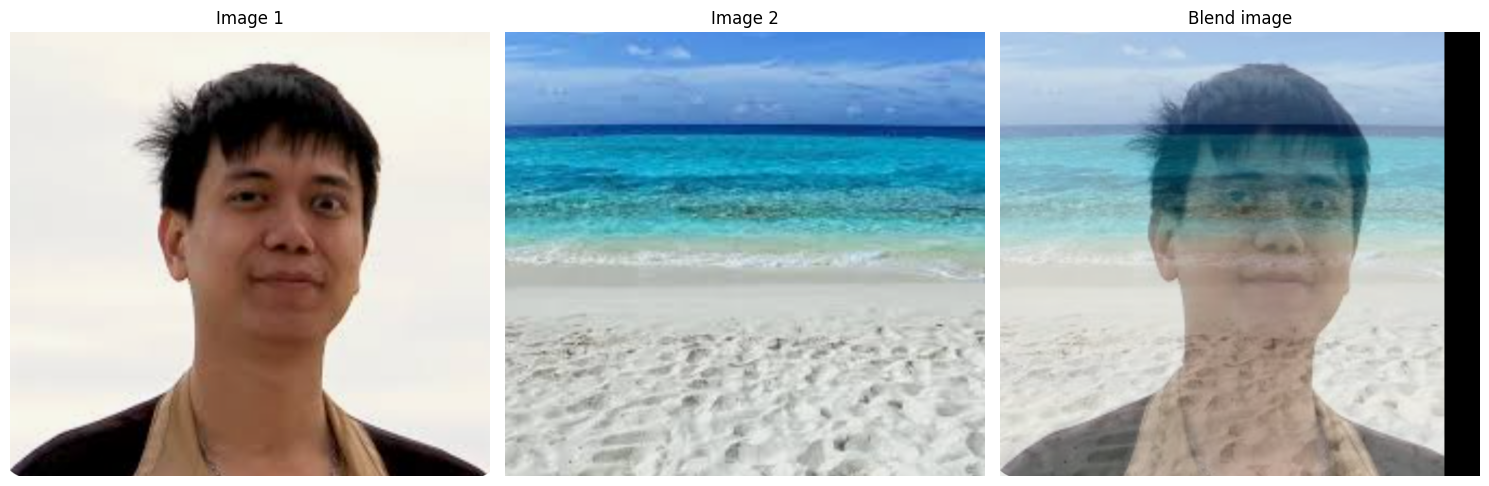

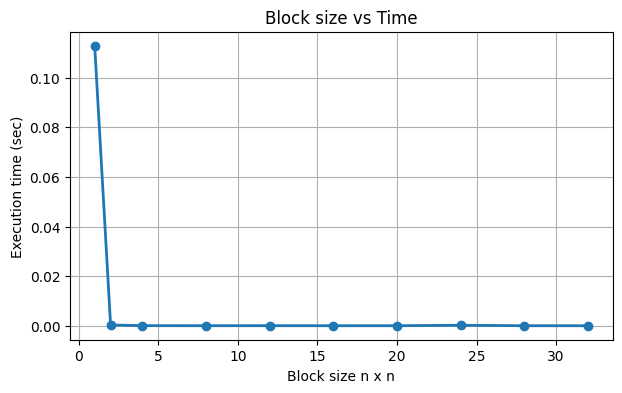

In [64]:
#### Blending ####

from PIL import Image
import time
import numpy as np
from numba import cuda, config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

# Function to blend images
@cuda.jit   # For GPU
def blend_gpu(src1, src2, dst, w1, w2):
    tidx1, tidx2 = cuda.grid(2)
    if tidx1 < dst.shape[0] and tidx2 < dst.shape[1]: # Image limit
        dst[tidx2, tidx1, 0] = (w1 * src1[tidx2, tidx1, 0] + w2 * src2[tidx2, tidx1, 0]) / (w1 + w2) # The 3 pixels are blend
        dst[tidx2, tidx1, 1] = (w1 * src1[tidx2, tidx1, 1] + w2 * src2[tidx2, tidx1, 1]) / (w1 + w2)
        dst[tidx2, tidx1, 2] = (w1 * src1[tidx2, tidx1, 2] + w2 * src2[tidx2, tidx1, 2]) / (w1 + w2)

img1 = Image.open("/content/image1.PNG").convert("RGB") # Load image
rgb_array1 = np.array(img1, dtype=np.uint8)

img2 = Image.open("/content/image2.png").convert("RGB") # Load image
rgb_array2 = np.array(img2, dtype=np.uint8)
# Image are same size

dst = np.zeros_like(rgb_array2, dtype=np.uint8) # Allow memory
block_sizes = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32] # Different block size values
times = [] # Timer

d_src1 = cuda.to_device(rgb_array1)   # Input
d_src2 = cuda.to_device(rgb_array2)   # Input
d_dst = cuda.device_array_like(dst)  # Output
w1 = 0.5 # Weight image 1
w2 = 0.5 # Weight image 2

# The Loop
for threads_per_block in block_sizes:

    blocks_x = int(np.ceil(rgb_array1.shape[0] / threads_per_block))
    blocks_y = int(np.ceil(rgb_array1.shape[1] / threads_per_block))

    start_time = time.time() # Timer
    blend_gpu[(blocks_x, blocks_y), (threads_per_block, threads_per_block)](d_src1, d_src2, d_dst, w1, w2) # Function for greyscaling
    end_time = time.time()

    d_dst.copy_to_host(dst)

    time_ = end_time - start_time # Timer
    times.append(time_)
    print(f"Block size = {threads_per_block} x {threads_per_block}  ->  Time taken = {time_:.6f} sec")

# Display and result
result = d_dst.copy_to_host()
result_c = np.clip(result, 0, 255).astype(np.uint8) # Converting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Image 1')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Image 2')
axes[2].imshow(result_c)
axes[2].axis('off')
axes[2].set_title('Blend image')
plt.tight_layout()
plt.show()

# Graph
plt.figure(figsize=(7,4))
plt.plot(block_sizes, times, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Block size n x n')
plt.ylabel('Execution time (sec)')
plt.title('Block size vs Time')
plt.grid(True)
plt.show()

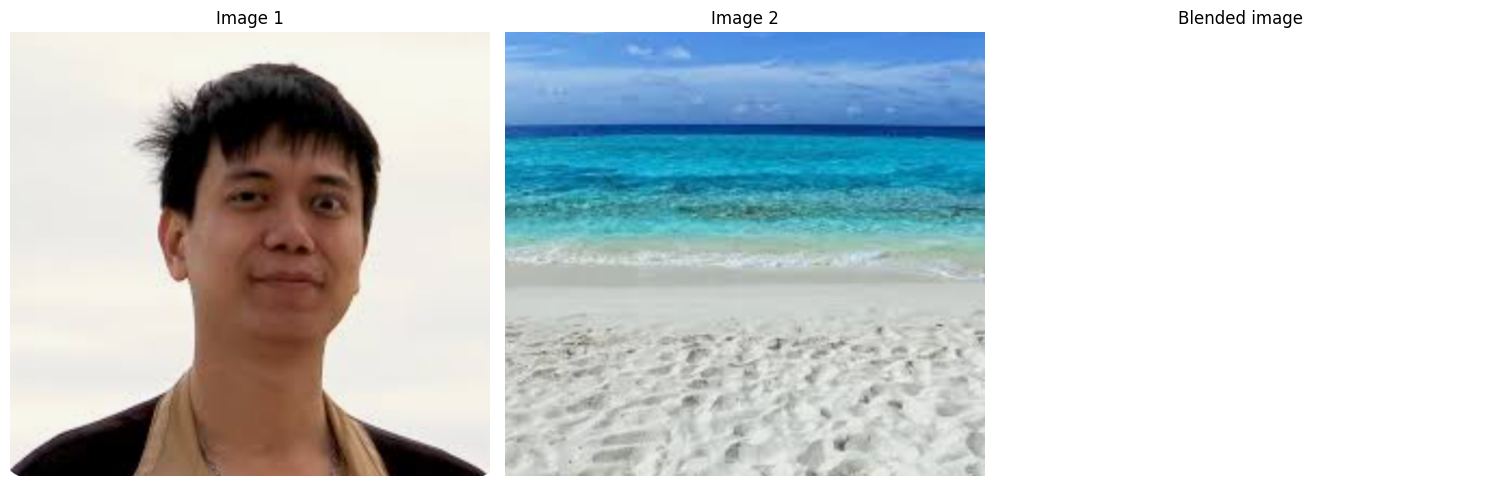

In [46]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt

@cuda.jit
def blend_images_cuda(image1, image2, output, weight1, weight2):
    # Get the thread's unique position in the image
    height, width = output.shape[0], output.shape[1]
    x, y = cuda.grid(2)

    if x < width and y < height:
        # Blend the RGB values for the corresponding pixel
        for c in range(3):  # RGB channels
            output[y, x, c] = (weight1 * image1[y, x, c] + weight2 * image2[y, x, c]) / (weight1 + weight2)

def blend_images(image1, image2, weight1, weight2):
    # Ensure input images are the same size
    assert image1.shape == image2.shape, "Input images must have the same dimensions."

    height, width, channels = image1.shape
    output = np.zeros_like(image1, dtype=np.uint8)

    # Define CUDA grid dimensions
    threads_per_block = (16, 16)
    blocks_per_grid_x = (width + (threads_per_block[0] - 1)) // threads_per_block[0]
    blocks_per_grid_y = (height + (threads_per_block[1] - 1)) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Transfer data to the device
    d_image1 = cuda.to_device(image1)
    d_image2 = cuda.to_device(image2)
    d_output = cuda.to_device(output)

    # Launch the kernel
    blend_images_cuda[blocks_per_grid, threads_per_block](d_image1, d_image2, d_output, weight1, weight2)

    # Copy the result back to host
    d_output.copy_to_host(output)

    return output

# Example usage
if __name__ == "__main__":
    # Load your images as NumPy arrays (example shape: (height, width, 3))
    # image1 = np.random.randint(0, 255, (512, 512, 3), dtype=np.uint8)
    # image2 = np.random.randint(0, 255, (512, 512, 3), dtype=np.uint8)
    img1 = Image.open('/content/image1.PNG')
    image1 = np.array(img1)

    img2 = Image.open('/content/image2.png')
    image2 = np.array(img2)


    weight1 = 0.5
    weight2 = 0.5

    blended_img = blend_images(image1, image2, weight1, weight2)



    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1)
    axes[0].axis('off')  # Hide axes for a cleaner look
    axes[0].set_title('Image 1')

    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title('Image 2')

    axes[2].imshow(blended_img)
    axes[2].axis('off')
    axes[2].set_title('Blended image')

    # Show the images
    plt.tight_layout()
    plt.show()
